In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from datetime import timedelta
import copy
import datetime, calendar
import shap
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import SMOTE

## Inits

In [32]:
year = 2020
month = 10
num_days = calendar.monthrange(year, month)[1]
days = [datetime.date(year, month, day) for day in range(1, num_days+1)]

pt = PowerTransformer()

model_dict = {
    "lr": LogisticRegression(),
    "xgb": XGBClassifier(),
    
}



In [33]:
# train/test split
def split_func(input, target, features):
  y_train = input.loc[input["split"] == "train", target]
  y_test = input.loc[input["split"] == "test", target]
          
  X_train = input.loc[input["split"] == "train", features]
  X_test = input.loc[input["split"] == "test", features]

  return X_train, y_train, X_test, y_test


# Define method for feature elimination according to correlation

def correlation(dataset, threshold):
    
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = abs(dataset.corr())
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return col_corr






## Pipeline

In [47]:
import warnings
warnings.filterwarnings('ignore')


pipe_dict = {}

fitted_pipe_dict = {
    "lr": {"roc_auc":[], "f1":[], "pr_auc":[]},
    "xgb": {"roc_auc":[], "f1":[], "pr_auc":[]},
    
}

for the_day in days:

    the_day = the_day.strftime('%Y-%m-%d')
    train_test_df = pd.read_pickle(f'./data/train_test_df_{the_day}.pkl')
    correlation(train_test_df, 0.7)
    print(the_day)

    # algorithm loop
    for algorithm_name, model in model_dict.items():


        continous = [x for x in copy.deepcopy(train_test_df.columns.to_list()) if x not in ["userid", "currentbugroupname", "label", "split", "same_gender", "same_age"]]
        cats = [x for x in copy.deepcopy(train_test_df.columns.to_list()) if x in ["same_gender", "same_age"]]
        feats = continous + cats

        #print(feats)

        # train test split
        X_train, y_train, X_test, y_test = split_func(train_test_df, "label", feats)

        # transform the dataset
        #oversample = SMOTE(sampling_strategy='minority', k_neighbors=5)
        #X_train, y_train = oversample.fit_resample(X_train, y_train)

        # pipeline
        ct = ColumnTransformer([('norm_cnt', pt, continous)], remainder='passthrough', n_jobs=1)  
        pipe = Pipeline([("ct",ct),(algorithm_name, model)])
        pipe.fit(X_train, y_train)

        # save pipe
        pipe_dict[algorithm_name] = pipe
        

        # pred features
        pred_test = pipe.predict(X_test)
        pred_proba_test = pipe.predict_proba(X_test)

        pos_preds = [x for x in pred_test if x == 1.0]
        #print(X_test.shape, len(pos_preds))


        #metrics
        met = precision_recall_fscore_support(y_test, pred_test, average='weighted')
        aps = average_precision_score(y_test, pred_proba_test[:,1], average='micro', pos_label=1.0)
        auc =roc_auc_score(y_test, pred_proba_test[:,1])

        fitted_pipe_dict[f"{algorithm_name}"]["f1"].append(met[2])
        fitted_pipe_dict[f"{algorithm_name}"]["roc_auc"].append(auc)
        fitted_pipe_dict[f"{algorithm_name}"]["pr_auc"].append(aps)
        #print(f"{algorithm_name}", met, aps, auc)





2020-10-01
(4281, 9) 7
(4281, 9) 357
2020-10-02
(6237, 10) 0
(6237, 10) 480
2020-10-03
(7495, 10) 0
(7495, 10) 777
2020-10-04
(8781, 11) 33
(8781, 11) 1129
2020-10-05
(13966, 11) 10
(13966, 11) 1685
2020-10-06
(23252, 11) 1
(23252, 11) 1256
2020-10-07
(24961, 11) 0
(24961, 11) 856
2020-10-08
(26648, 10) 0
(26648, 10) 363
2020-10-09
(20512, 10) 6
(20512, 10) 366
2020-10-10
(18648, 10) 10
(18648, 10) 446
2020-10-11
(18271, 10) 3
(18271, 10) 372
2020-10-12
(19250, 10) 7
(19250, 10) 489
2020-10-13
(19234, 10) 11
(19234, 10) 541
2020-10-14
(19125, 11) 20
(19125, 11) 440
2020-10-15
(18869, 10) 12
(18869, 10) 405
2020-10-16
(19389, 11) 6
(19389, 11) 343
2020-10-17
(19700, 11) 8
(19700, 11) 524
2020-10-18
(21268, 11) 6
(21268, 11) 555
2020-10-19
(21705, 10) 21
(21705, 10) 579
2020-10-20
(23342, 10) 12
(23342, 10) 632
2020-10-21
(24356, 10) 20
(24356, 10) 448
2020-10-22
(23350, 10) 24
(23350, 10) 407
2020-10-23
(21945, 10) 18
(21945, 10) 357
2020-10-24
(22316, 9) 10
(22316, 9) 319
2020-10-25
(2

In [35]:
## Results
for key1 in fitted_pipe_dict.keys():
    for key2 in fitted_pipe_dict[key1].keys():

        fitted_pipe_dict[key1][key2] = np.mean(np.asarray(fitted_pipe_dict[key1][key2]))

display(pd.DataFrame.from_dict(fitted_pipe_dict, orient='columns'))

,lr,xgb
roc_auc,0.645983,0.593772
f1,0.841690,0.840509
pr_auc,0.162922,0.140354


## Feature Importance

In [36]:
# shap plot
def shap_plot(algorithm_name, train_input, test_input, categorial_feats, continous_feats, categorial_scaler, continous_scaler, pipeline):

      X_test_transformed = pipeline["ct"].transform(test_input)
      X_test_transformed_df = pd.DataFrame(X_test_transformed.astype(float), columns =  continous_feats + categorial_feats)


      if algorithm_name != "lr":
          shap_explainer = shap.TreeExplainer(pipeline[algorithm_name])
      else:
          print(X_test_transformed_df.shape)
          print(X_test_transformed.shape)
          shap_explainer = shap.LinearExplainer(pipeline[algorithm_name], X_test_transformed)

      shap_values = shap_explainer.shap_values(X_test_transformed)


      shap.summary_plot(shap_values.astype(float),
                                  X_test_transformed_df,
                                  show=False)
      plt.show()

(21524, 9)
(21524, 9)


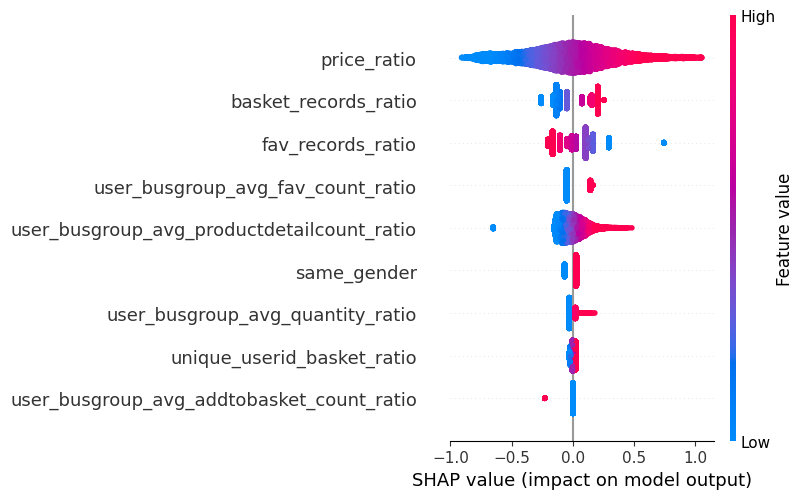

In [37]:
shap_plot("lr", 
          X_train, 
          X_test, 
          cats, 
          continous, 
          None, 
          pipe_dict["lr"]["ct"].transformers[0][1], 
          pipe_dict["lr"])

# Inference for df_test

In [51]:
df_test = pd.read_pickle(f'./data/df_test_features.csv.pkl')
#print(df_test.columns.values)

# pred features
pred_test = pipe_dict["lr"].predict(df_test[feats])
pred_proba_test = pipe_dict["lr"].predict_proba(df_test[feats])

pos_preds = [x for x in pred_test if x == 1.0]
print(len(pos_preds))

#fill necessary features
df_test["probability"] = pred_proba_test[:,1]
df_test["target"] = pred_test

#save the df_test
df_test[["userid", "currentbugroupname", "probability", "target"]].to_csv("./df_test.csv")

0
